In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt
import pandas as pd

In [8]:
spark = SparkSession.builder.appName('testKMeans').getOrCreate()

In [11]:
df = spark.read.format("csv").option("header","true").load("fb_live_thailand.csv")

In [15]:

df = df.select(df.num_sads.cast(DoubleType()),df.num_reactions.cast(DoubleType()))

In [16]:
vec_assembler = VectorAssembler(inputCols=['num_sads','num_reactions'],outputCol='features')

In [17]:
scaler = StandardScaler(inputCol='features',outputCol='scaledFeatures',withStd=True,withMean=False)

In [18]:
k_values = []

In [21]:
for i in range(2,5):
    kmeans = KMeans(featuresCol='scaledFeatures',predictionCol='cluster',k=i)
    pipeline = Pipeline(stages=[vec_assembler,scaler,kmeans])
    model = pipeline.fit(df)
    output = model.transform(df)
    evaluator = ClusteringEvaluator(predictionCol='cluster',featuresCol='scaledFeatures',metricName='silhouette',distanceMeasure='squaredEuclidean')

    score = evaluator.evaluate(output)
    k_values.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.8870485911324794
Silhouette Score: 0.9222692618451699
Silhouette Score: 0.9281101063954209


In [22]:
best_k = k_values.index(max(k_values))+2
print("The best k", best_k,max(k_values))

The best k 4 0.9281101063954209


In [23]:
kmeans = KMeans(featuresCol= "scaledFeatures",
                predictionCol="prediction_col",
                k = best_k)


In [24]:
pipeline = Pipeline(stages=[vec_assembler,scaler,kmeans])

In [25]:
model = pipeline.fit(df)

In [26]:
predictions = model.transform(df)

In [27]:
evaluator = ClusteringEvaluator(predictionCol='prediction_col',featuresCol='scaledFeatures',metricName='silhouette',distanceMeasure='squaredEuclidean')

In [28]:
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean = "+str(silhouette))

Silhouette with squared euclidean = 0.9281101063954209


In [29]:
clustering_data_pd = predictions.toPandas()

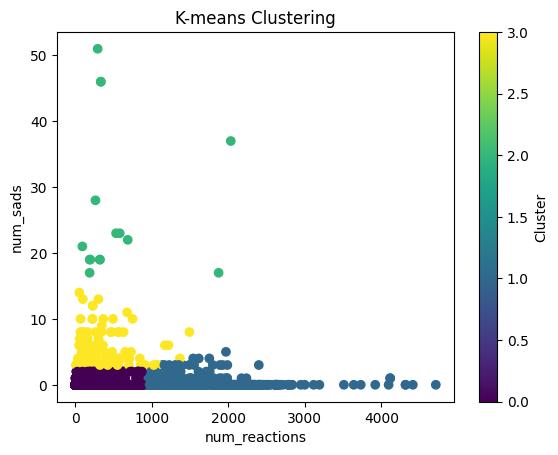

In [32]:
plt.scatter(clustering_data_pd['num_reactions'],clustering_data_pd['num_sads'],c=clustering_data_pd['prediction_col'])
plt.xlabel('num_reactions')
plt.ylabel('num_sads')
plt.title("K-means Clustering")
plt.colorbar().set_label('Cluster')
plt.show()